**Введение** 
    
    Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

    Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Подготовка

### Импорт библиотек

In [1]:
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

## Получение данных

### Чтение файлов


Откроем все доступные нам датасеты и сохраним их в переменные

In [2]:
try:
    if platform.system() == 'Windows':
        # прочитаем файл с данными и сохраним в df (Windows)
        calls_df = pd.read_csv('datasets\\calls.csv')
        internet_df = pd.read_csv('datasets\\internet.csv')
        messages_df = pd.read_csv('datasets\\messages.csv')
        tariffs_df = pd.read_csv('datasets\\tariffs.csv')
        users_df = pd.read_csv('datasets\\users.csv')
    else:
        # прочитаем файл с данными с сохраним в df (UNIX-like)
        calls_df = pd.read_csv('/datasets/calls.csv')
        internet_df = pd.read_csv('/datasets/internet.csv')
        messages_df = pd.read_csv('/datasets/messages.csv')
        tariffs_df = pd.read_csv('/datasets/tariffs.csv')
        users_df = pd.read_csv('/datasets/users.csv')
except:
    print('Ошибка!')

Теперь посмотрим на каждый из них по отдельности

In [3]:
calls_df.info() # получим общую информацию о таблице
calls_df.head(10)  # выведем первые 10 строк таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Всего **202 607** строк (считай звонков), явных пропущенных значений нет, но есть звонки с длительностью **0.00** — с этим предстоит разобраться. В остальном, особых проблем пока не наблюдается. Стоит перевести столбец call_date в формат datetime, возможно как-то изменить формат столбца id.

In [4]:
internet_df.info() # получим общую информацию о таблице
internet_df.head(10)  # выведем первые 10 строк таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


В датафрейме **internet_df** ситуация слегка иная. Странных нулевых значений нет, зато откуда-то взялся не совсем понятный столбец Unnamed: 0. Наверное, стоит передать эту информацию бэкенду. Как и в прошлом датафрейме, нам предстоит перевести session_date в datetime. В остальном, пока проблем не видно. В этом датафрейме **149 395** строк — то есть столько было интернет сеансов.

А еще обнаружились нулевые сессии, таких почти 20 000:

In [5]:
internet_df[internet_df['mb_used']==0].shape[0]

19598

In [6]:
messages_df.info() # получим общую информацию о таблице
messages_df.head(10)  # выведем первые 10 строк таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


В датафрейме messages_df всё выглядит вообще замечательно! Нет явно пропущенных значений, все столбцы адекватные, всё красиво. Осталось только столбец message_date в datetime перевести. Тут **123 036 строк**, что равно **123 036** сообщениям.

In [7]:
tariffs_df.info() # получим общую информацию о таблице
tariffs_df.head(10)  # выведем первые 10 строк таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В датафрейме tariffs_df всего две строки — именно столько тарифов в компании «Мегалайн». Проблем с этим датафреймом не видно, разве что можно поменять порядок столбцов для наглядности.

In [8]:
users_df.info() # получим общую информацию о таблице
users_df.head(10)  # выведем первые 10 строк таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


В датафрейме users_df всего **500** строк, значит у нас есть данные на 500 клиентов. Опять же, столбец reg_date нужно перевести в datetime. Есть еще столбец churn_date, его тоже стоит перевести в datetime, но в этом столбце очень много пропущенных значений. Возможно, найдется и другое решение.

### Описание данных
Еще раз посмотрим, какие данные нам предоставлены, взяв их описание из описания проекта:

**Таблица users_df (информация о пользователях):**
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана
* Таблица calls_df (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages_df (информация о сообщениях):**
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet_df (информация об интернет-сессиях):**
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

**Таблица tariffs_df (информация о тарифах):**
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Описание тарифов
Там же возьмём описание тарифов:

**Тариф «Смарт»**
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### Выводы к этапу

Мы прочитали 5 csv-файлов и сохранили их как датафреймы в переменные **users_df**, **calls_df**, **messages_df**, **internet_df** и **tariffs_df**. Мы посмотрели информацию и первые 10 строк каждого датафрейма.

Далее нам необходимо сделать следующее:

* Во-первых, предобработать данные. Удалить лишние столбцы, преобразовать типы данных, проверить пропущенные и некорректные значения.
* Во-вторых, необходимо объединить информацию со всех датафреймов в один, чтобы провести исследование.
* В-третьих, необходимо провести собственно исследование. Сравнить пользователей двух тарифов, проанализировать поведение пользователей и понять какой тариф лучше.

## Предобработка данных



### Звонки

Снова взглянем на датафрейм с информацией по звонкам:

In [9]:
calls_df.info()  # получим общую информацию о таблице
display(calls_df.head(10))  # выведем первые 10 строк таблицы
calls = calls_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


Во-первых, округлим все звонки в большую сторону, так как по условию «Мегалайн» всегда округляет вверх значения минут и мегабайтов.

In [10]:
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype('int')
calls.head(10)  # выведем первые 10 строк таблицы

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
5,1000_5,2018-11-02,0,1000
6,1000_6,2018-10-18,0,1000
7,1000_7,2018-08-22,19,1000
8,1000_8,2018-09-15,19,1000
9,1000_9,2018-08-15,0,1000


Преобразуем дату звонка в формат datetime:

In [11]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d', errors='raise')
calls.info()  # получим общую информацию о таблице
calls.head(10)  # выведем первые 10 строк таблицы


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
5,1000_5,2018-11-02,0,1000
6,1000_6,2018-10-18,0,1000
7,1000_7,2018-08-22,19,1000
8,1000_8,2018-09-15,19,1000
9,1000_9,2018-08-15,0,1000


Так как у нас ежемесячная оплата по тарифам, нам необходимо создать дополнительный столбец с месяцем для группировки данных:

In [12]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls['year'] = pd.DatetimeIndex(calls['call_date']).year
calls.head(10)

,id,call_date,duration,user_id,month,year
0,1000_0,2018-07-25,0,1000,7,2018
1,1000_1,2018-08-17,0,1000,8,2018
2,1000_2,2018-06-11,3,1000,6,2018
3,1000_3,2018-09-21,14,1000,9,2018
4,1000_4,2018-12-15,6,1000,12,2018
5,1000_5,2018-11-02,0,1000,11,2018
6,1000_6,2018-10-18,0,1000,10,2018
7,1000_7,2018-08-22,19,1000,8,2018
8,1000_8,2018-09-15,19,1000,9,2018
9,1000_9,2018-08-15,0,1000,8,2018


На всякий случай проверим, не попался ли нам лишний год:

In [13]:
calls.groupby('year').count()

,id,call_date,duration,user_id,month
year,,,,,
2018,202607,202607,202607,202607,202607


In [14]:
#Всё нормально, столбец с годом можно убрать.
calls = calls.drop(['year'], axis=1)
calls.head(10) 

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
5,1000_5,2018-11-02,0,1000,11
6,1000_6,2018-10-18,0,1000,10
7,1000_7,2018-08-22,19,1000,8
8,1000_8,2018-09-15,19,1000,9
9,1000_9,2018-08-15,0,1000,8


У нас есть нулевые значения в столбце duration. Скорее всего эти значения отражают пропущенные звонки. Несмотря на то, что пропущенные звонки сами по себе не приносят денег, они могут дать нам дополнительную информацию. Поэтому удалять их не стоит. Наличие пропущенных звонков содержит в себе разные случаи: случайно пропущенные звонки (вызываемый абонент не знал, что ему звонят), звонки пропущенные из-за занятости (вызываемый абонент знал, что ему звонят, но не мог взять трубку), специально пропущенные звонки (вызываемый абонент не хотел разговаривать вообще, не хотел разговаривать с конкретным абонентом).

* Во-первых, потому что звонок уже доведён до абонента, что значит инфраструктура оператора всё равно совершила работу, а значит с точки зрения издержек эти значения могут быть важны.
* Во-вторых, часть пропущенных звонков может быть связана со спам-звонками и мошенническими схемами, а это значит что по этим звонкам можно оценить необходимость в улучшении фильтрации звонков и настройке фильтров. А информацию об абонентах, которые занимаются подозрительной активностью можно передать в службу безопасности для проверки.

Поэтому удалять эту информацию мы не будем.

Похожая ситуация и с нулевыми сессиями. Их мы тоже удалять не будем.

In [15]:
print(calls.sort_values(by = 'duration', ascending = False).head(10))

              id  call_date  duration  user_id  month
178737   1446_22 2018-11-07        38     1446     11
95088    1241_44 2018-09-06        38     1241      9
39777   1099_150 2018-08-14        37     1099      8
5865     1017_61 2018-11-13        37     1017     11
60889   1153_135 2018-11-16        36     1153     11
60747   1152_444 2018-06-25        36     1152      6
81767   1203_340 2018-06-05        35     1203      6
100841    1260_5 2018-12-28        35     1260     12
64283    1165_31 2018-11-16        35     1165     11
160004  1394_409 2018-08-31        35     1394      8


In [16]:
calls = calls.groupby(['user_id', 'month']).agg({'duration': ['sum', 'count']})
calls.columns = ['duration_sum', 'duration_count']
calls = calls.reset_index()
calls.info()
calls.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   user_id         3174 non-null   int64
 1   month           3174 non-null   int64
 2   duration_sum    3174 non-null   int64
 3   duration_count  3174 non-null   int64
dtypes: int64(4)
memory usage: 99.3 KB


,user_id,month,duration_sum,duration_count
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58
5,1000,10,350,57
6,1000,11,338,43
7,1000,12,333,46
8,1001,11,430,59
9,1001,12,414,63


### Интернет

In [17]:
#Снова взглянем на датафрейм с информацией по трафику:
internet_df.info()  # получим общую информацию о таблице
display(internet_df.head(10))  # выведем первые 10 строк таблицы
internet = internet_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


Преобразуем дату сеанса в формат datetime:

In [18]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d', errors='raise')
internet.info()  # получим общую информацию о таблице
internet.head(10)  # выведем первые 10 строк таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


Так как у нас ежемесячная оплата по тарифам, нам необходимо создать дополнительный столбец с месяцем для группировки данных:

In [19]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet['year'] = pd.DatetimeIndex(internet['session_date']).year
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id,month,year
0,0,1000_0,112.95,2018-11-25,1000,11,2018
1,1,1000_1,1052.81,2018-09-07,1000,9,2018
2,2,1000_2,1197.26,2018-06-25,1000,6,2018
3,3,1000_3,550.27,2018-08-22,1000,8,2018
4,4,1000_4,302.56,2018-09-24,1000,9,2018
5,5,1000_5,399.97,2018-10-02,1000,10,2018
6,6,1000_6,540.08,2018-09-07,1000,9,2018
7,7,1000_7,415.70,2018-07-11,1000,7,2018
8,8,1000_8,505.40,2018-10-08,1000,10,2018
9,9,1000_9,345.54,2018-09-03,1000,9,2018


На всякий случай проверим, не попался ли нам лишний год:

In [20]:
internet.groupby('year').count()

,Unnamed: 0,id,mb_used,session_date,user_id,month
year,,,,,,
2018,149396,149396,149396,149396,149396,149396


Всё нормально, год можно удалить. Заодно избавимся от столбца Unnamed: 0:

In [21]:
internet = internet.drop(['Unnamed: 0', 'year'], axis=1)
internet.head(10)

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9
5,1000_5,399.97,2018-10-02,1000,10
6,1000_6,540.08,2018-09-07,1000,9
7,1000_7,415.70,2018-07-11,1000,7
8,1000_8,505.40,2018-10-08,1000,10
9,1000_9,345.54,2018-09-03,1000,9


Теперь сгруппируем датафрейм:

In [22]:
internet = internet.groupby(['user_id', 'month']).agg({'mb_used': ['count', 'sum']})
internet.columns = ['mb_used_count', 'mb_used_sum']
internet = internet.reset_index()
internet.info()
internet.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        3203 non-null   int64  
 1   month          3203 non-null   int64  
 2   mb_used_count  3203 non-null   int64  
 3   mb_used_sum    3203 non-null   float64
dtypes: float64(1), int64(3)
memory usage: 100.2 KB


,user_id,month,mb_used_count,mb_used_sum
0,1000,5,5,2253.49
1,1000,6,49,23233.77
2,1000,7,29,14003.64
3,1000,8,29,14055.93
4,1000,9,27,14568.91
5,1000,10,27,14702.49
6,1000,11,24,14756.47
7,1000,12,21,9817.61
8,1001,11,55,18429.34
9,1001,12,41,14036.66


Построим гистограмму, чтобы проверить распределение значений.


<AxesSubplot:>

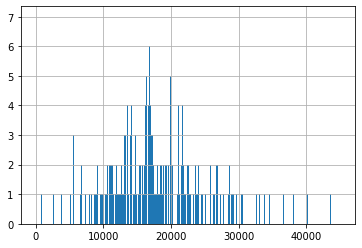

In [23]:
internet['mb_used_sum'].hist(bins=5000, range=(0, 45000))

Есть несколько выбросов в районе 40гб, но это вполне нормальное значение в используемом трафике.

### Сообщения

Снова взглянем на датафрейм с информацией по сообщениям:

In [24]:
messages_df.info()  # получим общую информацию о таблице
display(messages_df.head(10))  # выведем первые 10 строк таблицы
messages = messages_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Преобразуем дату сообщения в формат datetime:

In [25]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d', errors='raise')
messages.info()  # получим общую информацию о таблице
messages.head(10)  # выведем первые 10 строк таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


Так как у нас ежемесячная оплата по тарифам, нам необходимо создать дополнительный столбец с месяцем для группировки данных:

In [26]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages['year'] = pd.DatetimeIndex(messages['message_date']).year
messages.head(10)

,id,message_date,user_id,month,year
0,1000_0,2018-06-27,1000,6,2018
1,1000_1,2018-10-08,1000,10,2018
2,1000_2,2018-08-04,1000,8,2018
3,1000_3,2018-06-16,1000,6,2018
4,1000_4,2018-12-05,1000,12,2018
5,1000_5,2018-06-20,1000,6,2018
6,1000_6,2018-11-19,1000,11,2018
7,1000_7,2018-10-29,1000,10,2018
8,1000_8,2018-06-25,1000,6,2018
9,1000_9,2018-12-18,1000,12,2018


In [27]:
#На всякий случай проверим, не попался ли нам лишний год:
messages.groupby('year').count()

,id,message_date,user_id,month
year,,,,
2018,123036,123036,123036,123036


Всё нормально, год можно удалить.

In [28]:
messages = messages.drop(['year'], axis=1)
messages.head(10)

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
5,1000_5,2018-06-20,1000,6
6,1000_6,2018-11-19,1000,11
7,1000_7,2018-10-29,1000,10
8,1000_8,2018-06-25,1000,6
9,1000_9,2018-12-18,1000,12


Теперь сгруппируем датафрейм:

In [29]:
messages = messages.groupby(['user_id', 'month']).agg({'id': ['count']})
messages.columns = ['message_count']
messages = messages.reset_index()
messages.info()
messages.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   user_id        2717 non-null   int64
 1   month          2717 non-null   int64
 2   message_count  2717 non-null   int64
dtypes: int64(3)
memory usage: 63.8 KB


,user_id,month,message_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


### Тарифы

Снова взглянем на датафрейм с информацией по тарифам:

In [30]:
tariffs_df.info()  # получим общую информацию о таблице
display(tariffs_df.head(10))  # выведем первые 10 строк таблицы
tariffs = tariffs_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Как уже говорили выше, проблем тут не видно, так что просто поменяем порядок столбцов для наглядности:

In [31]:
tariffs.rename(columns={'tariff_name': 'tariff'}, inplace=True)
cols = ['tariff', 'rub_monthly_fee', 'minutes_included', 'rub_per_minute', 'mb_per_month_included', 'rub_per_gb', 
        'messages_included', 'rub_per_message']
tariffs = tariffs[cols]
tariffs.info()  # получим общую информацию о таблице
tariffs.head(10)  # выведем первые 10 строк таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   tariff                 2 non-null      object
 1   rub_monthly_fee        2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_per_minute         2 non-null      int64 
 4   mb_per_month_included  2 non-null      int64 
 5   rub_per_gb             2 non-null      int64 
 6   messages_included      2 non-null      int64 
 7   rub_per_message        2 non-null      int64 
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,tariff,rub_monthly_fee,minutes_included,rub_per_minute,mb_per_month_included,rub_per_gb,messages_included,rub_per_message
0,smart,550,500,3,15360,200,50,3
1,ultra,1950,3000,1,30720,150,1000,1


### Пользователи

Снова взглянем на датафрейм с информацией по пользователям:

In [32]:
users_df.info()  # получим общую информацию о таблице
display(users_df.head(10))  # выведем первые 10 строк таблицы
users = users_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


Так как информация у нас за 2018 год, значит всем кто не покинул оператора мы можем поствить churn_date 2018-12-31. А чтобы отличить выбывших пользователей, добавим столбец is_churn.

In [33]:
users.loc[users['churn_date'].isnull(), 'is_churn'] = False
users.loc[~users['churn_date'].isnull(), 'is_churn'] = True
users.loc[users['churn_date'].isnull(), 'churn_date'] = '2018-12-31'
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d', errors='raise')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d', errors='raise')
users['days_used'] = users['churn_date'] - users['reg_date']
users.info() # получим общую информацию о таблице
users.head(10)  # выведем первые 10 строк таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   user_id     500 non-null    int64          
 1   age         500 non-null    int64          
 2   churn_date  500 non-null    datetime64[ns] 
 3   city        500 non-null    object         
 4   first_name  500 non-null    object         
 5   last_name   500 non-null    object         
 6   reg_date    500 non-null    datetime64[ns] 
 7   tariff      500 non-null    object         
 8   is_churn    500 non-null    object         
 9   days_used   500 non-null    timedelta64[ns]
dtypes: datetime64[ns](2), int64(2), object(5), timedelta64[ns](1)
memory usage: 39.2+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,is_churn,days_used
0,1000,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,False,220 days
1,1001,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart,False,60 days
2,1002,59,2018-12-31,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,False,197 days
3,1003,23,2018-12-31,Москва,Белла,Белякова,2018-08-17,ultra,False,136 days
4,1004,68,2018-12-31,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,False,231 days
5,1005,67,2018-12-31,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,False,340 days
6,1006,21,2018-12-31,Ульяновск,Леонид,Ермолаев,2018-02-26,smart,False,308 days
7,1007,65,2018-12-31,Москва,Юна,Березина,2018-04-19,smart,False,256 days
8,1008,63,2018-12-31,Челябинск,Рустэм,Пономарёв,2018-12-19,smart,False,12 days
9,1009,24,2018-12-31,Пермь,Василиса,Блинова,2018-03-22,smart,False,284 days


А теперь поменяем порядок столбцов:

In [34]:
cols = ['user_id', 'first_name', 'last_name', 'age', 'city', 'tariff', 'reg_date', 'churn_date', 'days_used', 'is_churn']
users = users[cols]
users.info() # получим общую информацию о таблице
users.head(10)  # выведем первые 10 строк таблицы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   user_id     500 non-null    int64          
 1   first_name  500 non-null    object         
 2   last_name   500 non-null    object         
 3   age         500 non-null    int64          
 4   city        500 non-null    object         
 5   tariff      500 non-null    object         
 6   reg_date    500 non-null    datetime64[ns] 
 7   churn_date  500 non-null    datetime64[ns] 
 8   days_used   500 non-null    timedelta64[ns]
 9   is_churn    500 non-null    object         
dtypes: datetime64[ns](2), int64(2), object(5), timedelta64[ns](1)
memory usage: 39.2+ KB


,user_id,first_name,last_name,age,city,tariff,reg_date,churn_date,days_used,is_churn
0,1000,Рафаил,Верещагин,52,Краснодар,ultra,2018-05-25,2018-12-31,220 days,False
1,1001,Иван,Ежов,41,Москва,smart,2018-11-01,2018-12-31,60 days,False
2,1002,Евгений,Абрамович,59,Стерлитамак,smart,2018-06-17,2018-12-31,197 days,False
3,1003,Белла,Белякова,23,Москва,ultra,2018-08-17,2018-12-31,136 days,False
4,1004,Татьяна,Авдеенко,68,Новокузнецк,ultra,2018-05-14,2018-12-31,231 days,False
5,1005,Афанасий,Горлов,67,Набережные Челны,smart,2018-01-25,2018-12-31,340 days,False
6,1006,Леонид,Ермолаев,21,Ульяновск,smart,2018-02-26,2018-12-31,308 days,False
7,1007,Юна,Березина,65,Москва,smart,2018-04-19,2018-12-31,256 days,False
8,1008,Рустэм,Пономарёв,63,Челябинск,smart,2018-12-19,2018-12-31,12 days,False
9,1009,Василиса,Блинова,24,Пермь,smart,2018-03-22,2018-12-31,284 days,False


### Объединение данных

Для того, чтобы перейти к анализу данных, нам необходимо объединить всю информацию в один датафрейм.

In [35]:
df = calls
df = df.merge(internet, on=['user_id', 'month'], how='outer')
df = df.merge(messages, on=['user_id', 'month'], how='outer')
df = df.merge(users[['user_id','tariff', 'age', 'city', 'reg_date', 'churn_date', 'days_used', 'is_churn']], on='user_id')
df = df.merge(tariffs, on='tariff')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   user_id                3214 non-null   int64          
 1   month                  3214 non-null   int64          
 2   duration_sum           3174 non-null   float64        
 3   duration_count         3174 non-null   float64        
 4   mb_used_count          3203 non-null   float64        
 5   mb_used_sum            3203 non-null   float64        
 6   message_count          2717 non-null   float64        
 7   tariff                 3214 non-null   object         
 8   age                    3214 non-null   int64          
 9   city                   3214 non-null   object         
 10  reg_date               3214 non-null   datetime64[ns] 
 11  churn_date             3214 non-null   datetime64[ns] 
 12  days_used              3214 non-null   timedelta

Слегка поменяем порядок колонок и заменим пропущенные значения в кол-во минут разговора и соответственно в сумме, так как есть месяцы, когда абоненты не использовали тариф для общения, но пользовались интернетом. Скорее всего пользователь мог использовать интернет связь для общения:

In [36]:
cols = ['user_id', 'tariff', 'age', 'city', 'reg_date', 'churn_date', 'days_used', 'is_churn', 'month', 'duration_count', 
        'duration_sum', 'mb_used_count', 'mb_used_sum', 'message_count', 'rub_monthly_fee', 'minutes_included', 
        'rub_per_minute', 'mb_per_month_included', 'rub_per_gb', 'messages_included', 'rub_per_message']
df = df[cols]
df['duration_count'] = df['duration_count'].fillna(0)
df['duration_sum'] = df['duration_sum'].fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   user_id                3214 non-null   int64          
 1   tariff                 3214 non-null   object         
 2   age                    3214 non-null   int64          
 3   city                   3214 non-null   object         
 4   reg_date               3214 non-null   datetime64[ns] 
 5   churn_date             3214 non-null   datetime64[ns] 
 6   days_used              3214 non-null   timedelta64[ns]
 7   is_churn               3214 non-null   object         
 8   month                  3214 non-null   int64          
 9   duration_count         3214 non-null   float64        
 10  duration_sum           3214 non-null   float64        
 11  mb_used_count          3203 non-null   float64        
 12  mb_used_sum            3203 non-null   float64  

Остались еще нулевые значения, нужно их проверить.
- Есть люди, которые не отправляют сообщения, поэтому скорее всего они их не отправляли. Заменим кол-во значений на 0.
- Скорее всего не все пользуются интернетом и не у всех устройства позволяют им пользоваться. Так же заменим пропущенные значения на 0.

In [37]:
df['mb_used_count'] = df['mb_used_count'].fillna(0)
df['mb_used_sum'] = df['mb_used_sum'].fillna(0)
df['message_count'] = df['message_count'].fillna(0)
df.info()

    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   user_id                3214 non-null   int64          
 1   tariff                 3214 non-null   object         
 2   age                    3214 non-null   int64          
 3   city                   3214 non-null   object         
 4   reg_date               3214 non-null   datetime64[ns] 
 5   churn_date             3214 non-null   datetime64[ns] 
 6   days_used              3214 non-null   timedelta64[ns]
 7   is_churn               3214 non-null   object         
 8   month                  3214 non-null   int64          
 9   duration_count         3214 non-null   float64        
 10  duration_sum           3214 non-null   float64        
 11  mb_used_count          3214 non-null   float64        
 12  mb_used_sum            3214 non-null   float64  

### Вывод

На этапе предобработки данных мы подготовили датафреймы для дальнейшего анализа. Мы преобразовали типы данных и значения, заполнили пропущенные значения, добавили новые столбцы и удалили ненужные. Так же мы подсчитали минимальные, максимальные, средние, медианные значения, количество и сумму по датафреймам со звонками, интернет трафиком и сообщениями. В конце мы собрали данные в общий датафрейм и теперь готовы приступить к анализу.

## Анализ данных

*Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.*

### Cреднее, дисперсия и стандартное отклонение

Для нахождения среднего значения и стандартного отклонения воспользуемся методом agg():

In [38]:
df_mds = df.groupby(['tariff'])['duration_sum', 'mb_used_sum', 'message_count'].agg(['mean', 'std', np.var])

df_mds.columns = ['duration_sum_mean', 'duration_sum_std', 'duration_sum_var', 'mb_used_sum_mean', 'mb_used_sum_std', 
'mb_used_sum_var', 'message_count_mean', 'message_count_std', 'message_count_var']
df_mds = df_mds.reset_index()

df_mds['mb_used_sum_var'] = df_mds['mb_used_sum_var'].round(2)
df_mds_dur = df_mds[['tariff', 'duration_sum_mean', 'duration_sum_std', 'duration_sum_var']]
df_mds_int = df_mds[['tariff', 'mb_used_sum_mean', 'mb_used_sum_std', 'mb_used_sum_var']]
df_mds_msg = df_mds[['tariff', 'message_count_mean', 'message_count_std', 'message_count_var']]

Cреднее, стандартное отклонение и дисперсия для минут разговора:

In [39]:
df_mds_dur.round(2)

,tariff,duration_sum_mean,duration_sum_std,duration_sum_var
0,smart,417.93,190.31,36219.32
1,ultra,526.62,317.61,100873.63


Cреднее, стандартное отклонение и дисперсия для мегабайт трафика:

In [40]:
df_mds_int.round(2)

,tariff,mb_used_sum_mean,mb_used_sum_std,mb_used_sum_var
0,smart,16208.39,5870.48,3.446250e+07
1,ultra,19468.81,10087.17,1.017510e+08


Cреднее, стандартное отклонение и дисперсия для количества сообщений:

In [41]:
df_mds_msg.round(2)

,tariff,message_count_mean,message_count_std,message_count_var
0,smart,33.38,28.23,796.81
1,ultra,49.36,47.80,2285.27


In [42]:
545.451104 / 3000

0.18181703466666665

Посмотрев на эти значения, можем сказать, что средние значения для тарифа smart меньше, чем для тарифа ultra. Дисперсия и стандартное отклонение для тарифа smart тоже меньше, поэтому значения будут ближе к среднему, а график распределения будет «сжат». Для тарифа ultra дисперсия и стандартное отклонение, напротив, больше — разброс значений намного больше, график будет «растянут».

### Графики распределения

Построим гистограммы по этим параметрам:

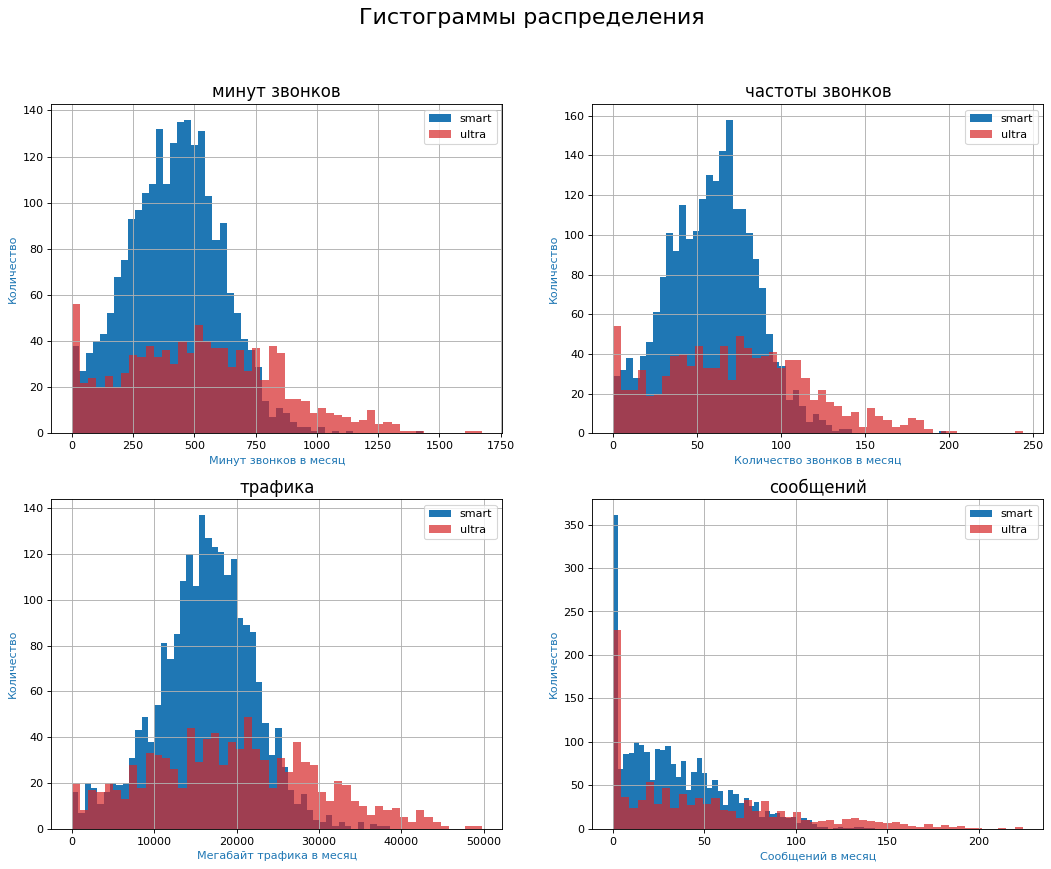

In [43]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(16,12), dpi=80)

x0, y0 = df.loc[df['tariff'] == 'smart', 'duration_sum'], df.loc[df['tariff'] == 'ultra', 'duration_sum']
x1, y1 = df.loc[df['tariff'] == 'smart', 'duration_count'], df.loc[df['tariff'] == 'ultra', 'duration_count']
x2, y2 = df.loc[df['tariff'] == 'smart', 'mb_used_sum'], df.loc[df['tariff'] == 'ultra', 'mb_used_sum']
x3, y3 = df.loc[df['tariff'] == 'smart', 'message_count'], df.loc[df['tariff'] == 'ultra', 'message_count']

#  гистограмма по звонкам без 0
ax0.hist(x0, 50, facecolor='tab:blue', alpha=1, label='smart')
ax0.hist(y0, 50, facecolor='tab:red', alpha=.7, label='ultra')
ax0.set_xlabel('Минут звонков в месяц', fontsize=10, color='tab:blue')
ax0.set_ylabel('Количество', fontsize=10, color='tab:blue')
ax0.set_title('минут звонков', fontsize=15)
ax0.legend()
ax0.grid(True)

#  гистограмма по звонкам с 0
ax1.hist(x1, 50, facecolor='tab:blue', alpha=1, label='smart')
ax1.hist(y1, 50, facecolor='tab:red', alpha=.7, label='ultra')
ax1.set_xlabel('Количество звонков в месяц', fontsize=10, color='tab:blue')
ax1.set_ylabel('Количество', fontsize=10, color='tab:blue')
ax1.set_title('частоты звонков', fontsize=15)
ax1.legend()
ax1.grid(True)

#  гистограмма по интернету
ax2.hist(x2, 50, facecolor='tab:blue', alpha=1, label='smart')
ax2.hist(y2, 50, facecolor='tab:red', alpha=.7, label='ultra')
ax2.set_xlabel('Мегабайт трафика в месяц', fontsize=10, color='tab:blue')
ax2.set_ylabel('Количество', fontsize=10, color='tab:blue')
ax2.set_title('трафика', fontsize=15)
ax2.legend()
ax2.grid(True)

#  гистограмма по сообщениям
ax3.hist(x3, 50, facecolor='tab:blue', alpha=1, label='smart')
ax3.hist(y3, 50, facecolor='tab:red', alpha=.7, label='ultra')
ax3.set_xlabel('Сообщений в месяц', fontsize=10, color='tab:blue')
ax3.set_ylabel('Количество', fontsize=10, color='tab:blue')
ax3.set_title('сообщений', fontsize=15)
ax3.legend()
ax3.grid(True)

fig.suptitle('Гистограммы распределения', fontsize=20)
plt.show()

И графики плотностей распределения:

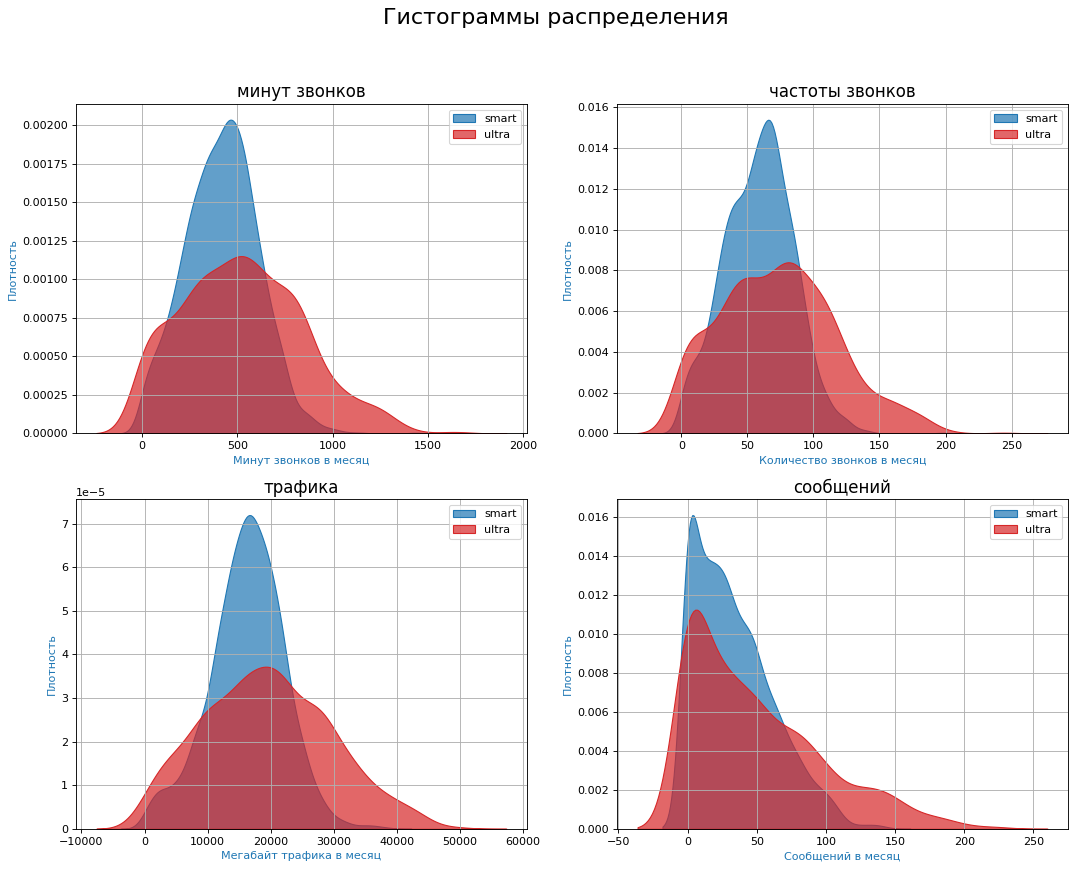

In [44]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(16,12), dpi=80)

#  гистограмма по звонкам без 0
sns.kdeplot(x0, ax=ax0, shade=True, color="tab:blue", label="smart", alpha=.7)
sns.kdeplot(y0, ax=ax0, shade=True, color="tab:red", label="ultra", alpha=.7)
ax0.set_xlabel('Минут звонков в месяц', fontsize=10, color='tab:blue')
ax0.set_ylabel('Плотность', fontsize=10, color='tab:blue')
ax0.set_title('минут звонков', fontsize=15)
ax0.legend()
ax0.grid(True)

#  гистограмма по звонкам с 0
sns.kdeplot(x1, ax=ax1, shade=True, color="tab:blue", label="smart", alpha=.7)
sns.kdeplot(y1, ax=ax1, shade=True, color="tab:red", label="ultra", alpha=.7)
ax1.set_xlabel('Количество звонков в месяц', fontsize=10, color='tab:blue')
ax1.set_ylabel('Плотность', fontsize=10, color='tab:blue')
ax1.set_title('частоты звонков', fontsize=15)
ax1.legend()
ax1.grid(True)

#  гистограмма по интернету
sns.kdeplot(x2, ax=ax2, shade=True, color="tab:blue", label="smart", alpha=.7)
sns.kdeplot(y2, ax=ax2, shade=True, color="tab:red", label="ultra", alpha=.7)
ax2.set_xlabel('Мегабайт трафика в месяц', fontsize=10, color='tab:blue')
ax2.set_ylabel('Плотность', fontsize=10, color='tab:blue')
ax2.set_title('трафика', fontsize=15)
ax2.legend()
ax2.grid(True)

#  гистограмма по сообщениям
sns.kdeplot(x3, ax=ax3, shade=True, color="tab:blue", label="smart", alpha=.7)
sns.kdeplot(y3, ax=ax3, shade=True, color="tab:red", label="ultra", alpha=.7)
ax3.set_xlabel('Сообщений в месяц', fontsize=10, color='tab:blue')
ax3.set_ylabel('Плотность', fontsize=10, color='tab:blue')
ax3.set_title('сообщений', fontsize=15)
ax3.legend()
ax3.grid(True)

fig.suptitle('Гистограммы распределения', fontsize=20)
plt.show()

На графиках наглядно подтвердились наши предположения. Видим, что значения по тарифу smart сильнее стремятся к среднему значению, чем значения по тарифу ultra.

### Вывод

Оценив среднее, дисперсию и стандартное отклонение, а также взглянув на графики распределения и гистограммы мы видим, что по звонкам и трафику распределение напоминает нормальное, а вот по сообщениям — скорее Пуассоновское. Кроме того, Значения по тарифу smart сильнее стремятся к среднему значению, чем значения по тарифу ultra. Если сравнить средние значения с тарифными лимитами, окажется что значения по тарифу smart близки к лимитам, а значения по трафику даже превышают его. Если же мы возьмём тариф ultra, то средние значения находятся очень далеко от лимитов. Только среднее значение по трафику составляет порядка двух третей от лимита. Значения по звонкам составляют не больше 20%, а по сообщениям — 10%.

Эти данные говорят нам о том, что лимиты тарифа smart действительно умные, и настроены вполне адекватно. А вот у тарифа ultra слишком большие лимиты — только малая часть пользователей использует его на полную. А вот тем клиентам тарифа smart, которые регулярно превышают лимиты, можно предложить перейти на тариф ultra.

## Проверка гипотез

### «Ультра» и «Смарт»: различается ли средняя выручка?

Теперь проверим гипотезы. Для начала сформулируем нулевую гипотезу — средняя выручка по тарифам «Ультра» и «Смарт» равна. Соответственно альтернативной гипотезой будет их неравенство.

Для начала посчитаем выручку по каждому клиенту за каждый месяц. Для этого напишем функцию, которая посчитает выручку, затем применим её к датафрейму и сохраним результат в столбец profit:

In [45]:
def profit_calc(df):
    #  объявляем переменные
    fee = calls_profit = internet_profit = messages_profit = 0
    fee = df['rub_monthly_fee']  #  заключаем стоимость тарифа в переменную
    
    #  считаем превышение ежемесячных лимитов
    calls = df['duration_sum'] - df['minutes_included']
    internet = (df['mb_used_sum'] - df['mb_per_month_included']) / 1024
    messages = df['message_count'] - df['messages_included']
    
    #  обнуляем отрицательные значения с помощью умножения на False
    calls *= (calls >= 0)
    internet *= (internet >= 0)
    messages *= (messages >= 0)
    
    #  считаем стоимость дополнительных услуг
    calls_profit = calls * df['rub_per_minute']
    internet_profit = np.ceil(internet) * df['rub_per_gb']
    messages_profit = messages * df['rub_per_message']
    
    #  возвращаем затраты пользователя за месяц
    return fee + calls_profit + internet_profit + messages_profit

df_profit = df
df_profit.fillna(pd.Timedelta(0))
df_profit['profit'] = profit_calc(df_profit)
df_profit.groupby('tariff')['profit'].mean()
df

,user_id,tariff,age,city,reg_date,churn_date,days_used,is_churn,month,duration_count,duration_sum,mb_used_count,mb_used_sum,message_count,rub_monthly_fee,minutes_included,rub_per_minute,mb_per_month_included,rub_per_gb,messages_included,rub_per_message,profit
0,1000,ultra,52,Краснодар,2018-05-25,2018-12-31,220 days,False,5,22.0,159.0,5.0,2253.49,22.0,1950,3000,1,30720,150,1000,1,1950.0
1,1000,ultra,52,Краснодар,2018-05-25,2018-12-31,220 days,False,6,43.0,172.0,49.0,23233.77,60.0,1950,3000,1,30720,150,1000,1,1950.0
2,1000,ultra,52,Краснодар,2018-05-25,2018-12-31,220 days,False,7,47.0,340.0,29.0,14003.64,75.0,1950,3000,1,30720,150,1000,1,1950.0
3,1000,ultra,52,Краснодар,2018-05-25,2018-12-31,220 days,False,8,52.0,408.0,29.0,14055.93,81.0,1950,3000,1,30720,150,1000,1,1950.0
4,1000,ultra,52,Краснодар,2018-05-25,2018-12-31,220 days,False,9,58.0,466.0,27.0,14568.91,57.0,1950,3000,1,30720,150,1000,1,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,smart,35,Санкт-Петербург,2018-08-15,2018-12-31,138 days,False,8,0.0,0.0,34.0,11050.56,17.0,550,500,3,15360,200,50,3,550.0
3210,1489,smart,35,Санкт-Петербург,2018-08-15,2018-12-31,138 days,False,9,0.0,0.0,63.0,17206.30,32.0,550,500,3,15360,200,50,3,950.0
3211,1489,smart,35,Санкт-Петербург,2018-08-15,2018-12-31,138 days,False,10,0.0,0.0,63.0,19559.44,21.0,550,500,3,15360,200,50,3,1550.0
3212,1489,smart,35,Санкт-Петербург,2018-08-15,2018-12-31,138 days,False,11,0.0,0.0,55.0,17491.56,20.0,550,500,3,15360,200,50,3,1150.0


Видим, что средние значения по тарифам отличаются.

Теперь построим графики:

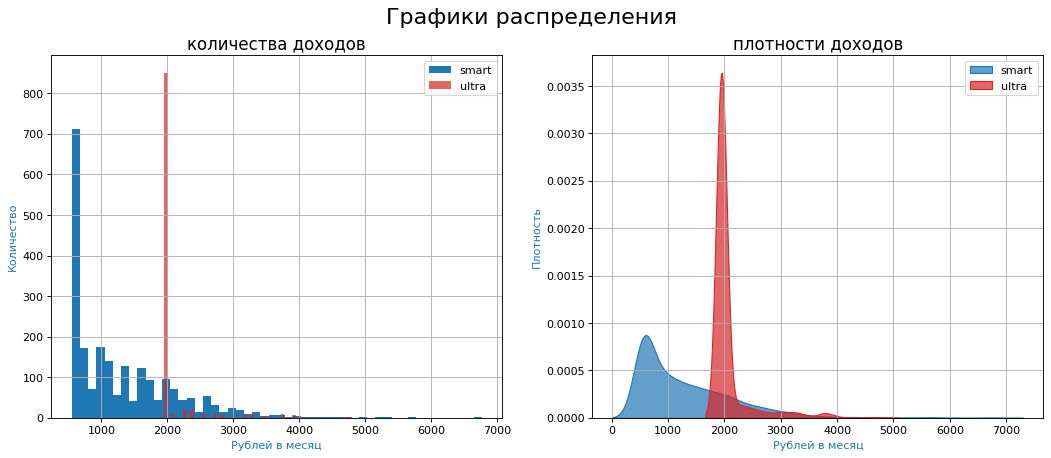

In [46]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,6), dpi=80)

x0, y0 = df_profit.loc[df_profit['tariff'] == 'smart', 'profit'], df_profit.loc[df_profit['tariff'] == 'ultra', 'profit']

#  гистограмма по звонкам без 0
ax0.hist(x0, 50, facecolor='tab:blue', alpha=1, label='smart')
ax0.hist(y0, 50, facecolor='tab:red', alpha=.7, label='ultra')
ax0.set_xlabel('Рублей в месяц', fontsize=10, color='tab:blue')
ax0.set_ylabel('Количество', fontsize=10, color='tab:blue')
ax0.set_title('количества доходов', fontsize=15)
ax0.legend()
ax0.grid(True)

#  гистограмма по звонкам с 0
sns.kdeplot(x0, ax=ax1, shade=True, color="tab:blue", label="smart", alpha=.7)
sns.kdeplot(y0, ax=ax1, shade=True, color="tab:red", label="ultra", alpha=.7)
ax1.set_xlabel('Рублей в месяц', fontsize=10, color='tab:blue')
ax1.set_ylabel('Плотность', fontsize=10, color='tab:blue')
ax1.set_title('плотности доходов', fontsize=15)
ax1.legend()
ax1.grid(True)

fig.suptitle('Графики распределения', fontsize=20)
plt.show()

Графики получились очень своеобразными, но кажется тоже разными. Но пойдём до конца и проверим гипотезу с помощью сравнения самих совокупностей. Возьмём α=.05:

In [47]:
df_smart = df_profit.loc[df_profit['tariff'] == 'smart', 'profit']
df_smart = df_smart.fillna(0)
df_ultra = df_profit.loc[df_profit['tariff'] == 'ultra', 'profit']
df_ultra = df_ultra.fillna(0)

alpha = .05
e_var = abs((np.var(df_smart) - np.var(df_ultra)) / np.var(df_ultra))
equal = e_var < alpha

results = st.ttest_ind(df_smart, df_ultra, equal_var=e_var)

print('различие выборок: {:.4%}'.format(e_var))
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Гипотеза не подтвердилась: средняя выручка различается")
else:
    print("Гипотеза подтвердилась: средняя выручка не различается")

различие выборок: 373.5592%
p-значение: 1.4229814360764067e-160
Гипотеза не подтвердилась: средняя выручка различается


Как видим, гипотеза не подтвердилась и средняя выручка с клиента в месяц по каждому тарифу действительно различается.

### Отличается ли средняя выручка пользователей из Москвы от выручки пользователей из других регионов?

Теперь сформулируем вторую гипотезу. Нулевая гипотеза: средняя выручка по пользователям из Москвы равна средней выручке по пользователям из других регионов. Альтернативной гипотезой будет их неравенство.

Теперь возьмём наш датафрейм и заменим все города, кроме Москвы на Другой:

In [48]:
df_cities = df_profit
df_cities.loc[df_cities['city'] != 'Москва', 'city'] = 'Другой'
df_cities.groupby('city')['profit'].mean()

city
Другой    1524.936227
Москва    1546.713584
Name: profit, dtype: float64

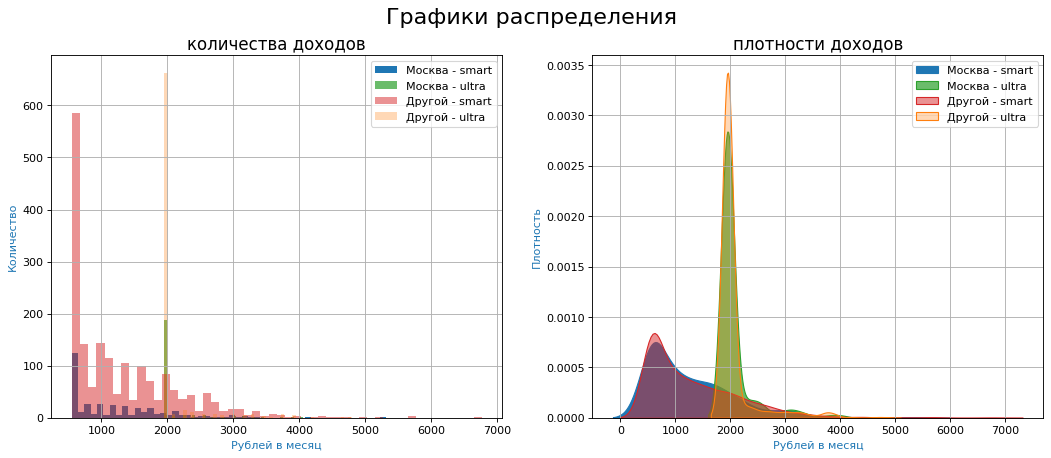

In [49]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,6), dpi=80)

x0 = df_cities.loc[(df_cities['tariff'] == 'smart') & (df_cities['city'] == 'Москва'), 'profit']
x1 = df_cities.loc[(df_cities['tariff'] == 'ultra') & (df_cities['city'] == 'Москва'), 'profit']
y0 = df_cities.loc[(df_cities['tariff'] == 'smart') & (df_cities['city'] == 'Другой'), 'profit']
y1 = df_cities.loc[(df_cities['tariff'] == 'ultra') & (df_cities['city'] == 'Другой'), 'profit']

#  гистограмма по звонкам без 0
ax0.hist(x0, 50, facecolor='tab:blue', alpha=1, label='Москва - smart')
ax0.hist(x1, 50, facecolor='tab:green', alpha=.7, label='Москва - ultra')
ax0.hist(y0, 50, facecolor='tab:red', alpha=.5, label='Другой - smart')
ax0.hist(y1, 50, facecolor='tab:orange', alpha=.3, label='Другой - ultra')
ax0.set_xlabel('Рублей в месяц', fontsize=10, color='tab:blue')
ax0.set_ylabel('Количество', fontsize=10, color='tab:blue')
ax0.set_title('количества доходов', fontsize=15)
ax0.legend()
ax0.grid(True)

#  гистограмма по звонкам с 0
sns.kdeplot(x0, ax=ax1, shade=True, color="tab:blue", label="Москва - smart", alpha=1)
sns.kdeplot(x1, ax=ax1, shade=True, color="tab:green", label="Москва - ultra", alpha=.7)
sns.kdeplot(y0, ax=ax1, shade=True, color="tab:red", label="Другой - smart", alpha=.5)
sns.kdeplot(y1, ax=ax1, shade=True, color="tab:orange", label="Другой - ultra", alpha=.3)
ax1.set_xlabel('Рублей в месяц', fontsize=10, color='tab:blue')
ax1.set_ylabel('Плотность', fontsize=10, color='tab:blue')
ax1.set_title('плотности доходов', fontsize=15)
ax1.legend()
ax1.grid(True)

fig.suptitle('Графики распределения', fontsize=20)
plt.show()

На графиках видим, что в Москве хоть и меньше пользователей, плотность их распределения почти не отличается от остальной России.

Далее сравним сами совокупности. Возьмём α=.05:

In [50]:
df_moscow = df_cities.loc[df_cities['city'] == 'Москва', 'profit']
df_moscow = df_moscow.fillna(0)
df_other = df_cities.loc[df_cities['city'] == 'Другой', 'profit']
df_other = df_other.fillna(0)

alpha = .05
e_var = abs((np.var(df_moscow) - np.var(df_other)) / np.var(df_other))
equal = e_var < alpha

results = st.ttest_ind(df_moscow, df_other, equal_var=e_var)

print('различие выборок: {:.4%}'.format(e_var))
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Гипотеза не подтвердилась: средняя выручка различается")
else:
    print("Гипотеза подтвердилась: средняя выручка не различается")

различие выборок: 13.6378%
p-значение: 0.5440152911670224
Гипотеза подтвердилась: средняя выручка не различается


Наши прошлые наблюдения подтвердились — средняя выручка по Москве и по остальной России отличается незначительно.

## Результаты исследования

### Общие выводы

В этом исследовании нас интересовали ответы на следующие вопросы:

* Какой тариф приносит больше денег?
* Пользователи «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.
* Различается ли средняя выручка пользователей тарифов «Ультра» и «Смарт»?
* Различается ли средняя выручка пользователей из Москвы от выручки пользователей из других регионов?

**Общие результаты**

В этом исследовании мы анализировали 500 клиентов компании «Мегалайн» и то, как они пользуются своими тарифами. Большая часть (&ap;70%) пользуется более дешёвым тарифом smart. При этом отток клиентов больше именно с более затратного тарифа ultra (&ap;10% у ultra против &ap;6% у smart). Вероятно это связано с тем, что лимиты тарифа ultra слишком большие, и большинство пользователей не в состоянии потратить их за месяц, поэтому они смотрят на тарифы с более низкими лимитами, которые наверняка окажутся дешевле.

Мы оценили среднее, дисперсию и стандартное отклонение, графики распределения и гистограммы мы видим, что по звонкам и трафику распределение напоминает нормальное, а вот по сообщениям — скорее Пуассоновское (Пуассоновское распределение в сообщениях скорее всего говорит нам о том, что этот способ связи всё менее актуален, потому что большинство современных людей общается в мессенджерах). Значения по тарифу smart сильнее стремятся к среднему значению, чем значения по тарифу ultra. Значения по тарифу smart близки к лимитам, а значения тарифа ultra находятся очень далеко от лимитов.

Мы сформулировали две нулевые гипотезы: «средняя выручка по тарифам «Ультра» и «Смарт» равна» и «средняя выручка по пользователям из Москвы равна средней выручке по пользователям из других регионов». Первая гипотеза не подтвердилась — выручка по тарифам оказалась разной. В среднем больше денег платят клиенты тарифа ultra, что неудивительно. Вторая гипотеза подтвердилась — выручка с клиента по Москве незначительно отличается от выручки в других городах.

На основании этого исследования мы сформулировали рекомендации, которые помогут улучшить бизнес-показатели компании «Мегалайн».

### Рекомендации

Несмотря на то, что по итогам исследования тариф ultra показал большую выручку с клиента, этот тариф не является оптимальным по нескольким причинам:

Лимиты тарифа слишком большие, и для большинства клиентов бесполезны. Это заставляет их задуматься о переходе на более приближённый к их потребностям тариф, который скорее всего окажется ещё и дешевле.
Отток клиентов с этого тарифа почти в два раза выше, что вероятно связано с излишними лимитами и высокой ценой, но необязательно ограничивается этим. В рамках исследования этого не видно, но возможно с тарифом есть и другие проблемы.
Затраты на поддержку тарифа вероятно выше, поэтому высокая выручка ещё не гарантирует прибыль.
В связи с этим предлагается два варианта:

* Изменить лимиты тарифа ultra и приблизить их к текущим средним значениям по звонкам, трафику и сообщениям. Соответственно снизить цену на тариф.
* Не изменять лимиты тарифа, а оставить его в этой ценовой категории, добавить премиальное обслуживание. Добавить тариф, который займёт нишу между smart и ultra (средний сегмент): подобрать его лимиты по текущим средним значениям тарифа ultra, установить среднюю стоимость обслуживания.

Что касается маркетинговых бюджетов, то для тарифа ultra необходимо скорректировать рекламную кампанию, судя по всему ЦА о нём недостаточно осведомлена. Для тарифа smart ситцация сложилась более благоприятная ситуация, большая часть абонентов вписывается в рамки тарифа. Поэтому рекомендуется сменить стратегию в отношении тарифа ultra, соответственно большую часть средств направить на продвижение этого тарифа.

Кроме того, рекомендуется отследить природу большого количества пропущенных звонков: возможно номера клиентов используются для спам-звонков и мошеннических схем. Также можно предложить адресатам этих звонков дополнительные услуги по фильтрации звонков, если они окажутся клиентами компании.